In [1]:
using Pkg
Pkg.activate("..")
using Revise
using FUSE
using FUSE.IMAS
using Plots; gr();

  Activating environment at `~/Coding/julia/FUSE/Project.toml`
┌ Info: Precompiling FUSE [e64856f0-3bb8-4376-b4b7-c03396503992]
└ @ Base loading.jl:1317
┌ Warning: Type annotations on keyword arguments not currently supported in recipes. Type information has been discarded
└ @ RecipesBase ~/.julia/packages/RecipesBase/3fzVq/src/RecipesBase.jl:117
┌ Warning: Type annotations on keyword arguments not currently supported in recipes. Type information has been discarded
└ @ RecipesBase ~/.julia/packages/RecipesBase/3fzVq/src/RecipesBase.jl:117
┌ Warning: Type annotations on keyword arguments not currently supported in recipes. Type information has been discarded
└ @ RecipesBase ~/.julia/packages/RecipesBase/3fzVq/src/RecipesBase.jl:117
┌ Warning: Type annotations on keyword arguments not currently supported in recipes. Type information has been discarded
└ @ RecipesBase ~/.julia/packages/RecipesBase/3fzVq/src/RecipesBase.jl:117
┌ Warning: Type annotations on keyword arguments not currently 

In [2]:
if false
    ϵ = 0.48
    κ = 1.68
    δ = 0.21
    R0 = 6.2
    B0 = 5.3
    ip = 15.E6
    beta_n = 1.0
    x_point=(5.0,-6.0)
    symmetric=true

    resolution = 129

    dd = IMAS.dd()
    resize!(dd.equilibrium.time_slice,1)
    FUSE.init(dd.equilibrium.time_slice[1]; B0, R0, ϵ, δ, κ, beta_n, ip, x_point=x_point)

    eqactor = FUSE.SolovevEquilibriumActor(dd.equilibrium.time_slice[1], symmetric=symmetric)
    @time FUSE.step(eqactor)
    dd.equilibrium.time_slice[1] = FUSE.finalize(eqactor, resolution, (maximum([R0*(1-ϵ*2),0.0]), R0*(1+ϵ*2)), (-R0*ϵ*κ*2, R0*ϵ*κ*2))
    dd.equilibrium.time_slice[1].global_quantities.li_3 = 1.0 # made up!
    dd.equilibrium.time_slice[1].time=0.0
    dd.equilibrium.time=[0.0]
    dd.equilibrium.vacuum_toroidal_field.r0=R0
    dd.equilibrium.vacuum_toroidal_field.b0=[B0]

    plot(dd.equilibrium.time_slice[1])
    dd.equilibrium.time_slice[1];
else
    filename=joinpath(dirname(abspath(@__FILE__)), "..", "sample","CAT_eq_ods.json")
    dd = IMAS.json2imas(filename);
    IMAS.flux_surfaces(dd.equilibrium);
end

equilibrium.ids_properties was skipped in IMAS.jl data dictionary


time ➡ 1-element Vector{Float64}
time_slice
｜[1]
｜｜boundary
｜｜｜elongation ➡ Function
｜｜｜elongation_lower ➡ Function
｜｜｜elongation_upper ➡ Function
｜｜｜geometric_axis
｜｜｜｜r ➡ Function
｜｜｜｜z ➡ Function
｜｜｜minor_radius ➡ Function
｜｜｜outline
｜｜｜｜r ➡ 91-element Vector{Float64}
｜｜｜｜z ➡ 91-element Vector{Float64}
｜｜｜squareness_lower_inner ➡ Function
｜｜｜squareness_lower_outer ➡ Function
｜｜｜squareness_upper_inner ➡ Function
｜｜｜squareness_upper_outer ➡ Function
｜｜｜triangularity ➡ Function
｜｜｜triangularity_lower ➡ Function
｜｜｜triangularity_upper ➡ Function
｜｜｜x_point
｜｜｜｜[1]
｜｜｜｜｜r ➡ 3.194865405982973
｜｜｜｜｜z ➡ -2.6679803806386997
｜｜｜｜[2]
｜｜｜｜｜r ➡ 4.449185197594817
｜｜｜｜｜z ➡ -0.0012635110785437957
｜｜global_quantities
｜｜｜beta_normal ➡ 3.513954187526015
｜｜｜beta_pol ➡ 2.2983831285611163
｜｜｜beta_tor ➡ 0.03051798289173166
｜｜｜energy_mhd ➡ Function
｜｜｜ip ➡ 8.120197499085797e6
｜｜｜length_pol ➡ 12.685418442183519
｜｜｜li_3 ➡ 0.4828948226608098
｜｜｜magnetic_axis
｜｜｜｜b_field_tor ➡ 6.292948078332784
｜｜｜｜r ➡ 4.44942

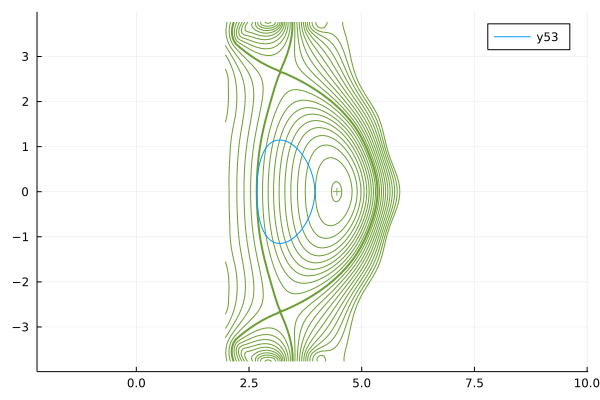

In [3]:
resize!(dd.equilibrium.time_slice,2);
eq=dd.equilibrium
eq.time_slice[2].global_quantities.psi_boundary=-0.12
α=0.25
eq.time_slice[2].boundary.outline.r,eq.time_slice[2].boundary.outline.z,_=IMAS.flux_surface(eq.time_slice[1],eq.time_slice[1].profiles_1d.psi[1]*(1-α)+eq.time_slice[1].profiles_1d.psi[end]*α)
eq.time_slice[2].boundary.outline.r.-=minimum(eq.time_slice[2].boundary.outline.r).-minimum(IMAS.flux_surface(eq.time_slice[1],eq.time_slice[1].profiles_1d.psi[end])[1])
eq.time_slice[2].time = -1.0
push!(eq.time,-1.0)

plot(dd.equilibrium.time_slice[1])
plot!(eq.time_slice[2].boundary.outline.r,eq.time_slice[2].boundary.outline.z)

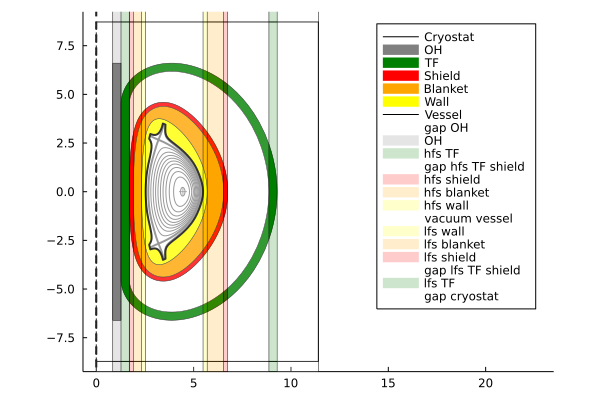

In [4]:
# initialize radial build IDS
eqt=dd.equilibrium.time_slice[1]

rb=dd.radial_build=IMAS.radial_build()
FUSE.init(rb, eqt, is_nuclear_facility=true, conformal_wall=true);

cp=dd.core_profiles=IMAS.core_profiles()
FUSE.init(cp, ejima=0.4);

# run FluxSwingActor
ohactor = FUSE.FluxSwingActor(rb, eq, cp)
FUSE.step(ohactor)
FUSE.finalize(ohactor)

plot(eqt,color=:gray)
plot!(rb,outline=true)
display(plot!(rb,cx=false))

In [5]:
# initialize pf actor
pfoptactor = PFcoilsOptActor(dd.equilibrium, dd.radial_build, [6, 4, 5]; coil_model=:point)
FUSE.step(pfoptactor, λ_ψ=1E-2, λ_null=1E-2, λ_currents=1E5, verbose=true, symmetric=true, maxiter=10000, optimization_scheme=:static);
FUSE.finalize(pfoptactor);

 * Status: success

 * Candidate solution
    Final objective value:     2.517645e-01

 * Found with
    Algorithm:     Nelder-Mead

 * Convergence measures
    √(Σ(yᵢ-ȳ)²)/n ≤ 1.0e-08

 * Work counters
    Seconds run:   4  (vs limit 120)
    Iterations:    186
    f(x) calls:    352



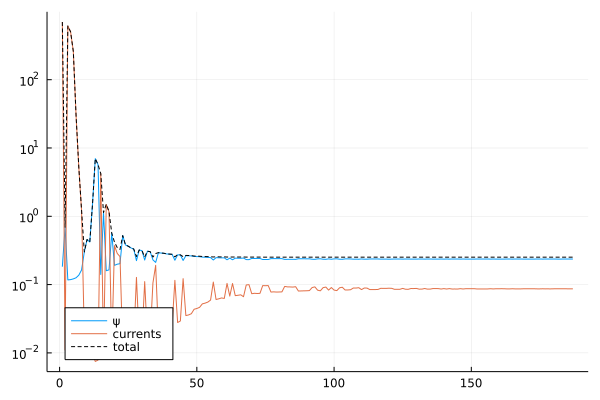

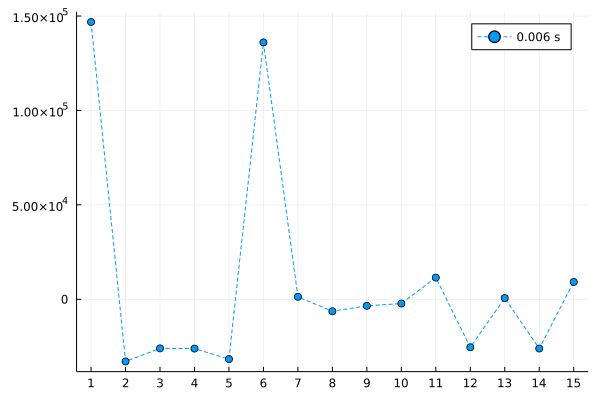

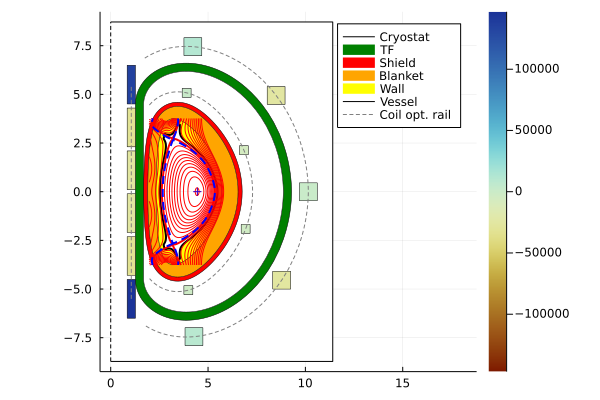

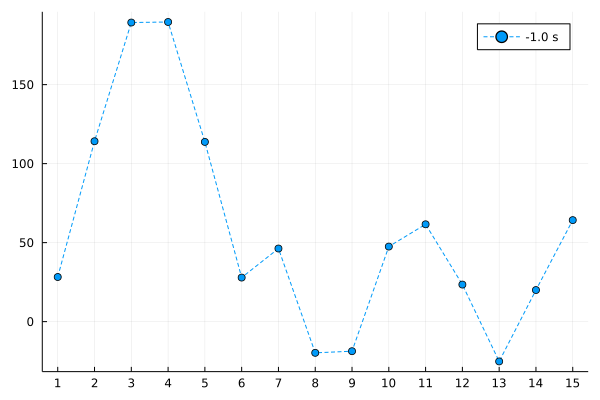

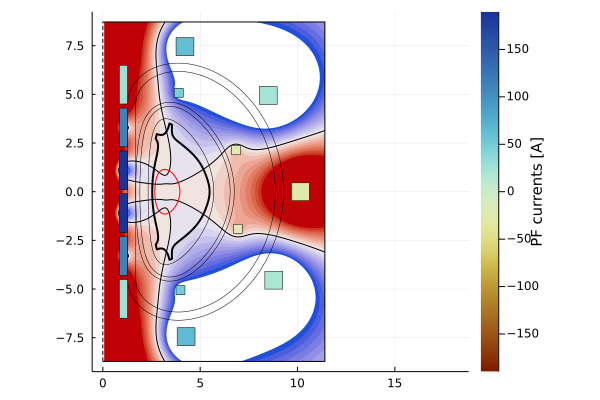

In [6]:
display(plot(pfoptactor.trace,:cost,start_at=1))

display(plot(pfoptactor.pf_active,:currents, time_index=1))
display(plot(pfoptactor,equilibrium=true,rail=true,time_index=1))

display(plot(pfoptactor.pf_active,:currents, time_index=2))
display(plot(pfoptactor,equilibrium=true,time_index=2))

In [7]:
# run pf actor
FUSE.step(pfoptactor, λ_ψ=1E-2, λ_null=1E-2, λ_currents=1E5, verbose=true, symmetric=true, maxiter=10000, optimization_scheme=:rail);
FUSE.finalize(pfoptactor);

 * Status: success

 * Candidate solution
    Final objective value:     1.820305e-01

 * Found with
    Algorithm:     Nelder-Mead

 * Convergence measures
    √(Σ(yᵢ-ȳ)²)/n ≤ 1.0e-08

 * Work counters
    Seconds run:   11  (vs limit 120)
    Iterations:    546
    f(x) calls:    942



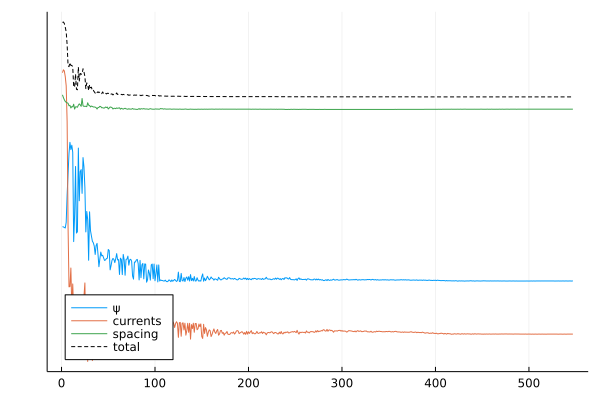

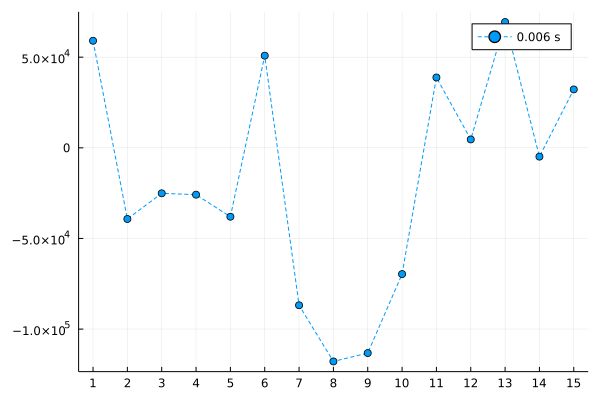

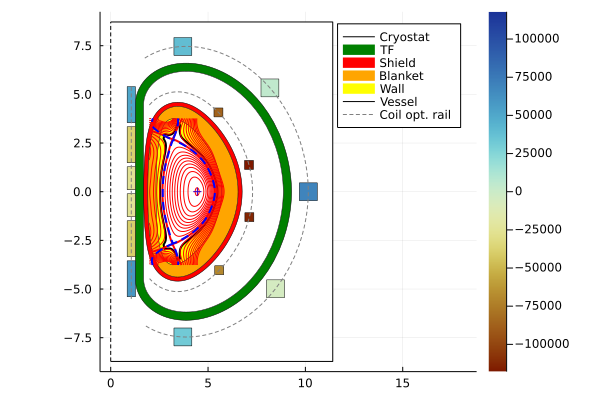

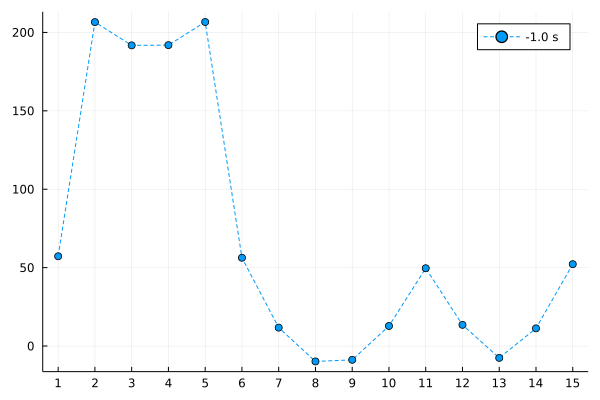

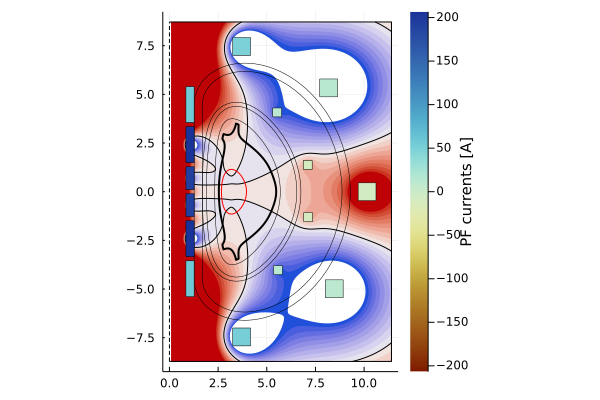

┌ Warning: No strict ticks found
└ @ PlotUtils /Users/meneghini/.julia/packages/PlotUtils/VgXdq/src/ticks.jl:294
┌ Warning: No strict ticks found
└ @ PlotUtils /Users/meneghini/.julia/packages/PlotUtils/VgXdq/src/ticks.jl:294


In [8]:
display(plot(pfoptactor.trace,:cost,start_at=1))

display(plot(pfoptactor.pf_active,:currents, time_index=1))
display(plot(pfoptactor,equilibrium=true,rail=true,time_index=1))

display(plot(pfoptactor.pf_active,:currents, time_index=2))
display(plot(pfoptactor,equilibrium=true,time_index=2,plot_r_buffer=1.0))

#IMAS.imas2json(rb,"radial_build_4.json")